In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from sktime.performance_metrics.forecasting import (
    mean_absolute_percentage_error,
    mean_absolute_error,
)

import seaborn as sns
import matplotlib.pyplot as plt
import random
from operator import itemgetter 

In [3]:
class CustRNN(nn.Module):
    def __init__(self, input_shape, output_shape, n_dense_1, n_dense_2, rnn_hidden_size, rnn_layers):
        super(CustRNN, self).__init__()
        self.rnn_hidden_size = rnn_hidden_size
        self.rnn_layers = rnn_layers

        self.rnn_layer = nn.RNN(input_size=input_shape,hidden_size=rnn_hidden_size,num_layers=rnn_layers, nonlinearity='relu', batch_first=True)
        self.layer_1 =  nn.Linear(rnn_hidden_size, n_dense_1)
        self.bn1 = nn.BatchNorm1d(num_features=n_dense_1)
        self.layer_2 =  nn.Linear(n_dense_1, n_dense_2)
        self.layer_3 =  nn.Linear(n_dense_1, output_shape, dtype= torch.float32)
        
        
    def forward(self, input):
        hidden_prev = torch.zeros(self.rnn_layers,input.size(0),self.rnn_hidden_size).to(input.device)
        x, hidden_nxt = self.rnn_layer(input,hidden_prev)
        # print(x.shape)
        x = F.relu(self.layer_1(x[:,-1,:]))
        # if x.dim()>1:
        #     x = self.bn1(x)
        # x = F.relu(self.layer_2(x))
        outputs = self.layer_3(x)
        return outputs

In [4]:
# Device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda:0


In [5]:
training_data = pd.read_csv('../train_df_2.csv')
training_data['arrival_date'] = pd.to_datetime(training_data['arrival_date'])
training_data = training_data.drop(['Unnamed: 0'], axis=1).sort_values('arrival_date')


PREDICTION_HORIZON = 30

TARGET_COLS = [f'RV{i}' for i in range(PREDICTION_HORIZON)] # ['RV0']
FEATURE_COLS = [f'RV{i}' for i in range(PREDICTION_HORIZON,100 + 1)]
target_data = training_data[TARGET_COLS]
feature_data = training_data[FEATURE_COLS]

In [6]:
target_data_tensor = torch.tensor(target_data.to_numpy(), dtype= torch.float32)
feature_data_tensor = torch.tensor(feature_data.to_numpy(), dtype= torch.float32).reshape(shape=((428,71,1)))

In [11]:
BATCH_SIZE = 30

train_dataset = torch.utils.data.TensorDataset(feature_data_tensor, target_data_tensor)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=BATCH_SIZE, shuffle=False)

### Training Loop

In [27]:
# training using the entire data set in each epoch
HIDDEN_SIZE = PREDICTION_HORIZON
RNN_LAYERS = 3
rnn_model = CustRNN( input_shape=1, output_shape=len(TARGET_COLS), n_dense_1=100, n_dense_2=100, rnn_hidden_size=HIDDEN_SIZE, rnn_layers=RNN_LAYERS)
rnn_model = rnn_model.to(DEVICE)

optimizer = torch.optim.Adam(rnn_model.parameters(), lr = 0.001)

hidden_prev = torch.randn(RNN_LAYERS, len(TARGET_COLS),HIDDEN_SIZE)
hidden_prev = hidden_prev.to(DEVICE)

cost_info_dct = {'epoch':[],'cost':[]}
for epoch in range(1500):

    cost_per_epoch = 0
    for inputs, targets in train_loader:

        inputs = inputs.to(DEVICE)
        targets=targets.to(DEVICE)

        pred = rnn_model(inputs)
        
        cost = nn.functional.mse_loss(pred,targets)
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        cost_per_epoch+=float(cost.cpu().detach())

    cost_info_dct['cost'].append(np.round(cost_per_epoch/len(train_loader), 3))
    cost_info_dct['epoch'].append(epoch)

    if epoch % 100==0:
        print('epoch:',epoch,' cost:',cost)



epoch: 0  cost: tensor(19149130., device='cuda:0', grad_fn=<MseLossBackward0>)
epoch: 100  cost: tensor(2752419.2500, device='cuda:0', grad_fn=<MseLossBackward0>)
epoch: 200  cost: tensor(2919250., device='cuda:0', grad_fn=<MseLossBackward0>)
epoch: 300  cost: tensor(2749141.7500, device='cuda:0', grad_fn=<MseLossBackward0>)
epoch: 400  cost: tensor(2338157., device='cuda:0', grad_fn=<MseLossBackward0>)
epoch: 500  cost: tensor(1970259.2500, device='cuda:0', grad_fn=<MseLossBackward0>)
epoch: 600  cost: tensor(1030550.8125, device='cuda:0', grad_fn=<MseLossBackward0>)
epoch: 700  cost: tensor(902597.3750, device='cuda:0', grad_fn=<MseLossBackward0>)
epoch: 800  cost: tensor(773699.3750, device='cuda:0', grad_fn=<MseLossBackward0>)
epoch: 900  cost: tensor(4771691., device='cuda:0', grad_fn=<MseLossBackward0>)
epoch: 1000  cost: tensor(576604.3125, device='cuda:0', grad_fn=<MseLossBackward0>)
epoch: 1100  cost: tensor(438974.4375, device='cuda:0', grad_fn=<MseLossBackward0>)
epoch: 1200

<Axes: xlabel='epoch', ylabel='cost'>

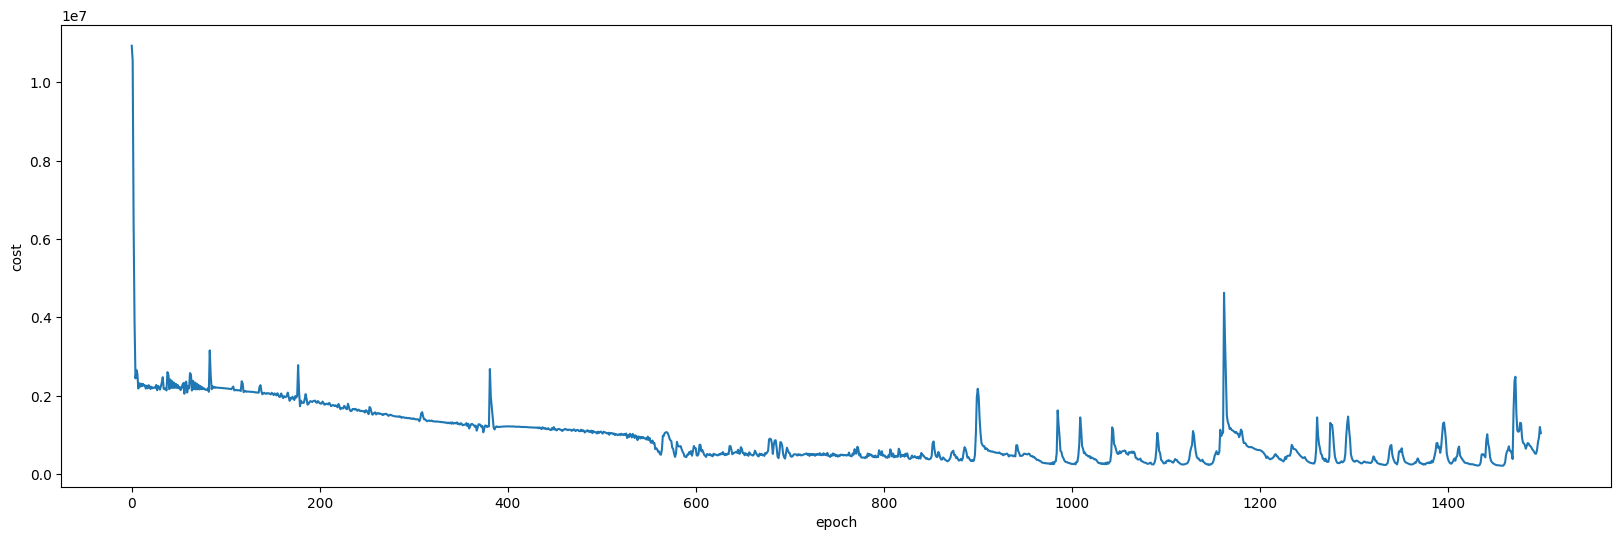

In [29]:
plt.figure(figsize=(20,6))
sns.lineplot(data=pd.DataFrame(cost_info_dct), x='epoch',y='cost')

#### Checking for overfitting

in sample SMAPE: 0.32320964
in sample MAE: 877.2218


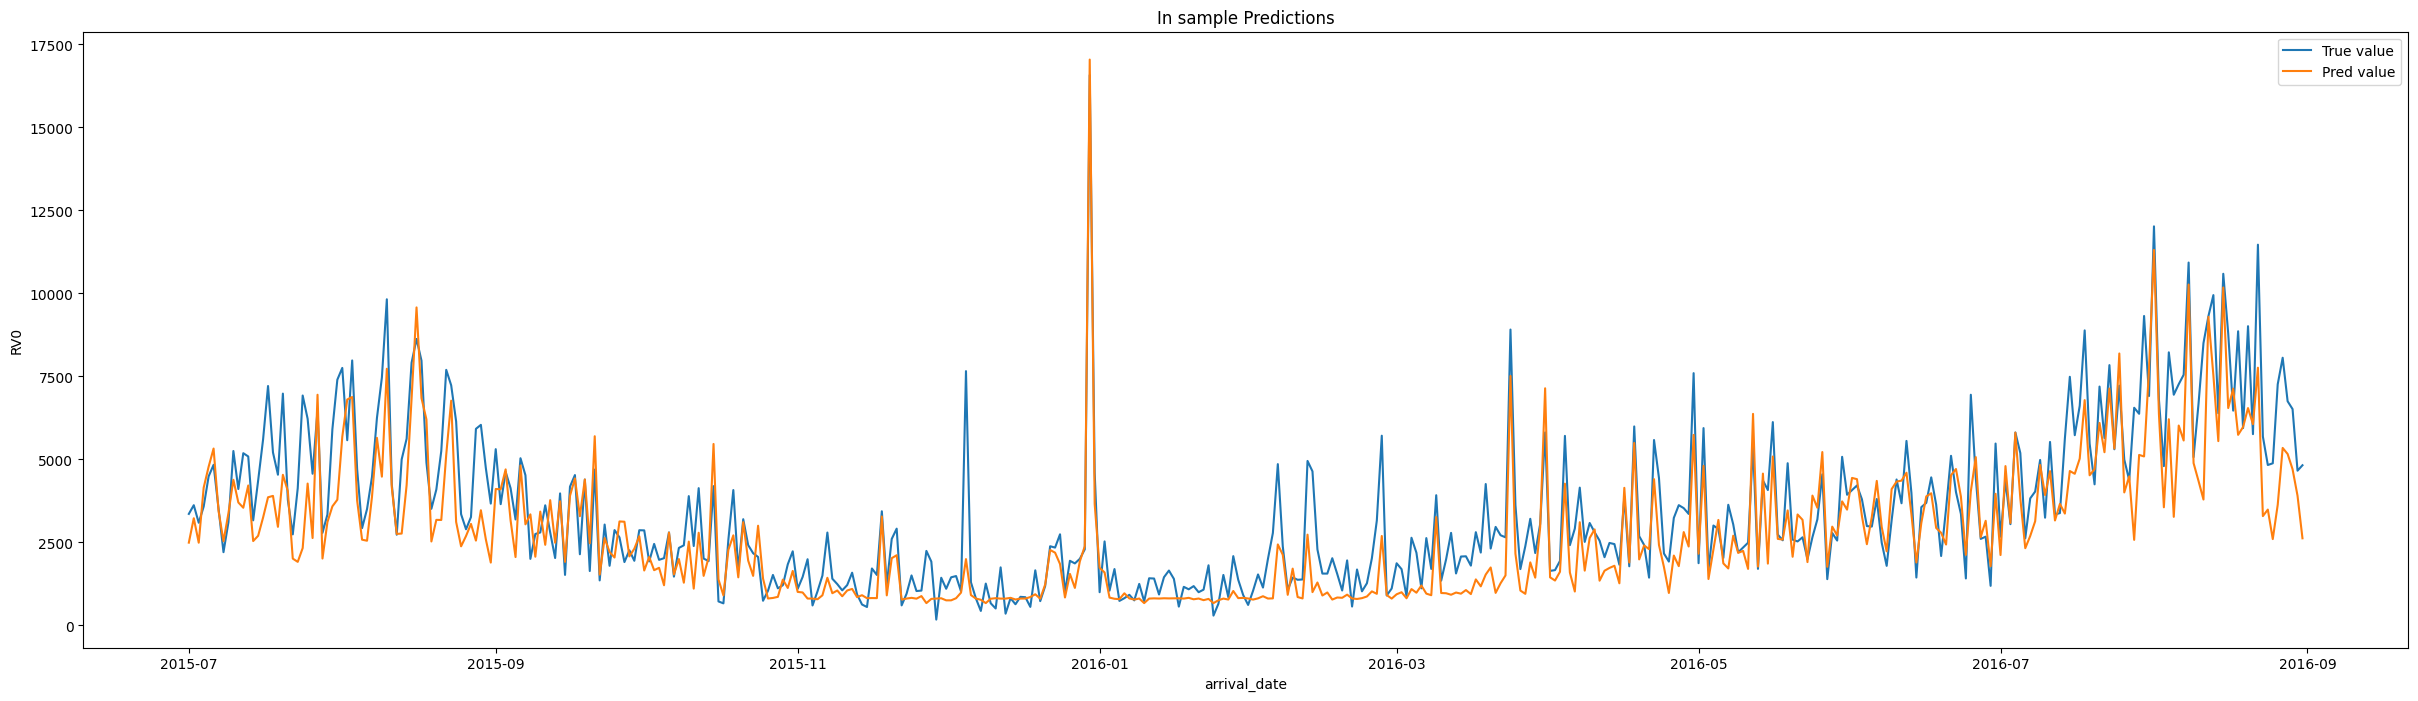

In [30]:
insample_test_loader =  torch.utils.data.DataLoader(dataset=train_dataset,batch_size=1, shuffle=False)
rnn_model.eval()

insample_pred_comparison = {'RV0':[], 'pred_RV0':[]}

for inputs, targets in insample_test_loader:
    insample_pred = rnn_model(inputs)
    insample_pred_comparison['RV0'].append(targets.cpu().detach().numpy()[0][0])
    insample_pred_comparison['pred_RV0'].append(insample_pred.cpu().detach().numpy()[0][0])

print('in sample SMAPE:',mean_absolute_percentage_error(y_pred=insample_pred_comparison['pred_RV0'], y_true=insample_pred_comparison[TARGET_COLS[0]], symmetric=True))
print('in sample MAE:',mean_absolute_error(y_pred=insample_pred_comparison['pred_RV0'], y_true=insample_pred_comparison[TARGET_COLS[0]]))

insample_pred_comparison_df = pd.concat([training_data[['arrival_date']],pd.DataFrame(insample_pred_comparison)],axis=1)

plt.figure(figsize=(30,8))
sns.lineplot(data=insample_pred_comparison_df, x = 'arrival_date', y=TARGET_COLS[0], label='True value')
sns.lineplot(data=insample_pred_comparison_df, x = 'arrival_date', y='pred_RV0', label='Pred value')
plt.title('In sample Predictions')
plt.legend()


#### Testing the RNN on out of sample predictions

In [31]:
test_df = pd.read_csv('../test_df_2.csv').reset_index(drop=True).drop('Unnamed: 0',axis=1)
test_df['arrival_date'] = pd.to_datetime(test_df['arrival_date'])

Out of sample SMAPE: 0.32393128
Out of sample MAE: 1042.2616


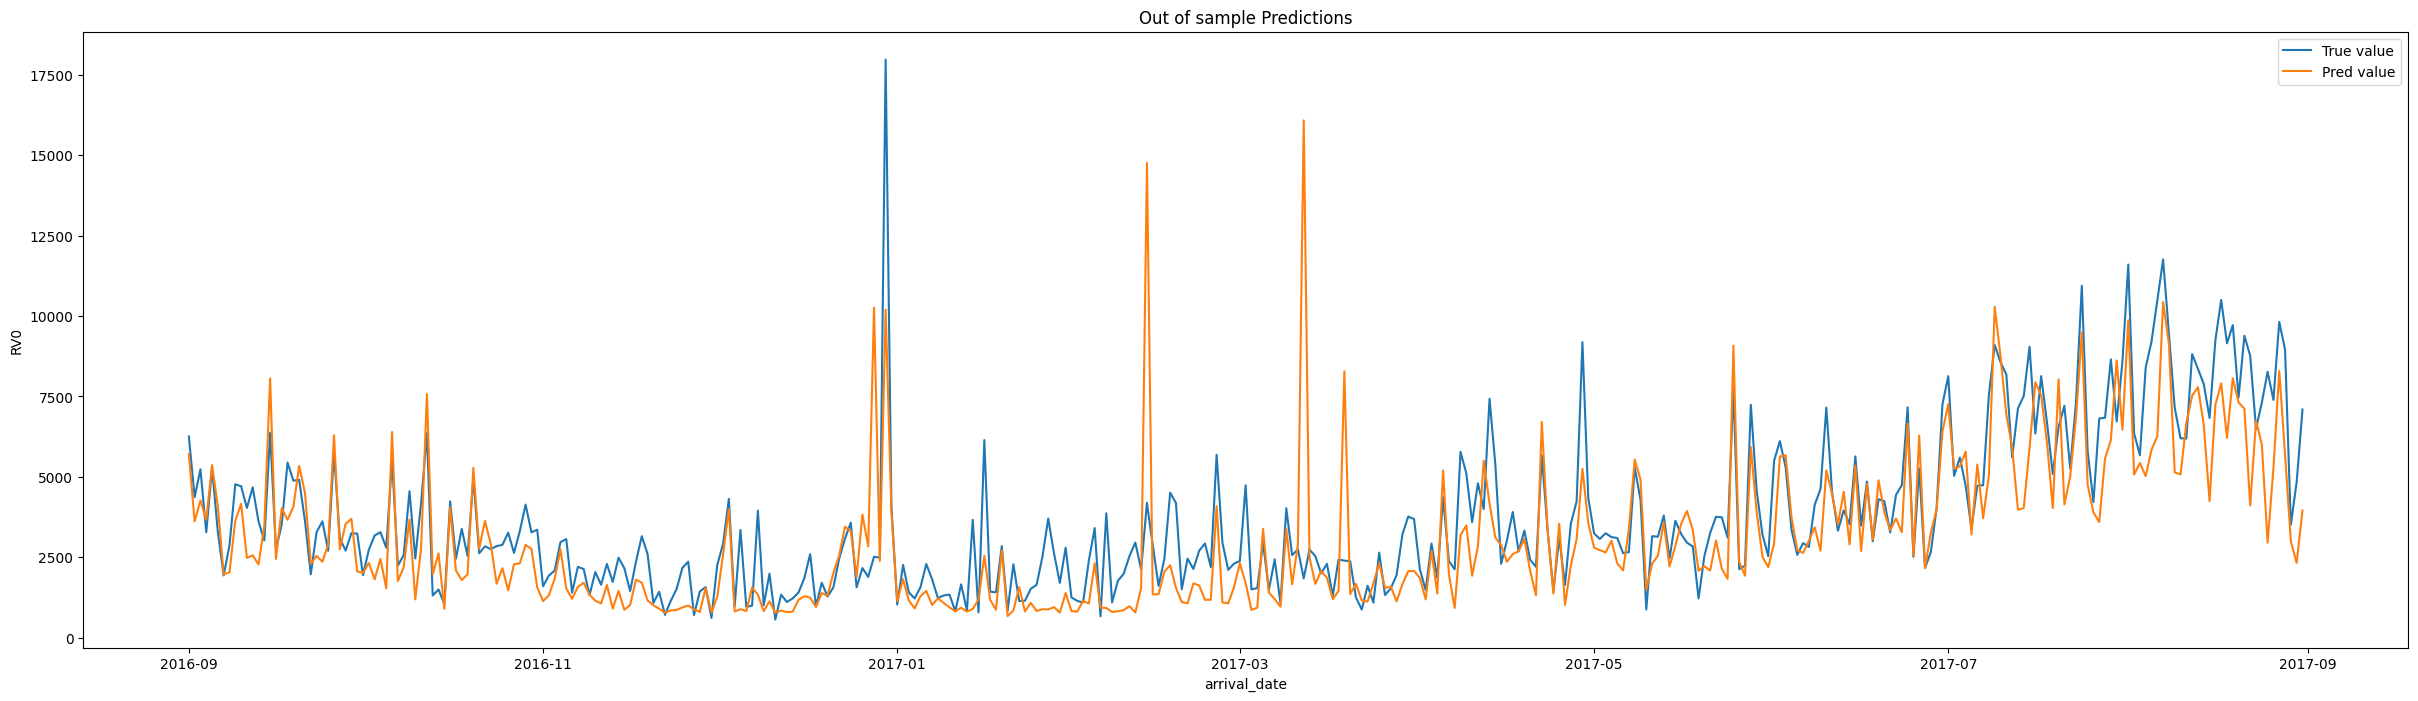

In [32]:
test_feature_data_tensor =torch.tensor(test_df[FEATURE_COLS].to_numpy(), dtype=torch.float32).reshape(shape=((len(test_df),71,1))).to(DEVICE)
test_target_data_tensor =torch.tensor(test_df[TARGET_COLS].to_numpy(), dtype=torch.float32).to(DEVICE)

test_dataset = torch.utils.data.TensorDataset(test_feature_data_tensor, test_target_data_tensor)
outsample_test_loader =  torch.utils.data.DataLoader(dataset=test_dataset,batch_size=1, shuffle=False)
rnn_model.eval()

outsample_pred_comparison = {'RV0':[], 'pred_RV0':[]}

for outsample_inputs, outsample_targets in outsample_test_loader:
    outsample_pred = rnn_model(outsample_inputs)
    outsample_pred_comparison['RV0'].append(outsample_targets.cpu().detach().numpy()[0][0])
    outsample_pred_comparison['pred_RV0'].append(outsample_pred.cpu().detach().numpy()[0][0])

print('Out of sample SMAPE:',mean_absolute_percentage_error(y_pred=outsample_pred_comparison['pred_RV0'], y_true=outsample_pred_comparison[TARGET_COLS[0]], symmetric=True))
print('Out of sample MAE:',mean_absolute_error(y_pred=outsample_pred_comparison['pred_RV0'], y_true=outsample_pred_comparison[TARGET_COLS[0]]))


outsample_pred_comparison_df = pd.concat([test_df[['arrival_date']],pd.DataFrame(outsample_pred_comparison)],axis=1)

plt.figure(figsize=(30,8))
sns.lineplot(data=outsample_pred_comparison_df, x = 'arrival_date', y=TARGET_COLS[0], label='True value')
sns.lineplot(data=outsample_pred_comparison_df, x = 'arrival_date', y='pred_RV0', label='Pred value')
plt.title('Out of sample Predictions')
plt.legend()


In [70]:
# running a realistic sliding window loop, 
# simulating a inferencing done every X days(X is the parameter freq in pd.date_range )

test_window_starts = pd.date_range(start=test_df.arrival_date.min(), 
                                   end=test_df.arrival_date.max(), 
                                   freq='5D')

all_eval_dfs = []
for window_start in test_window_starts:
    window_end = window_start+pd.to_timedelta(PREDICTION_HORIZON,unit='days')
    print(f"inferencing on {window_start} | target_stay_date: {window_end}")
    test_row = test_df[test_df.arrival_date==window_end]

    if len(test_row)>0:

        slide_test_data_tensor = torch.tensor(test_row[FEATURE_COLS].to_numpy(), dtype=torch.float32)
        slide_test_data_tensor = slide_test_data_tensor.to(DEVICE)

        slide_pred, hidden_output = rnn_model(slide_test_data_tensor,  hidden_prev)

        eval_df = test_row[TARGET_COLS].melt().rename(columns={'variable':'target', 'value':'y_true'})
        eval_df['y_pred'] = slide_pred.cpu().detach().numpy()[0]
        eval_df['eval_start'] = window_start
        eval_df['arrival_date'] = window_end
        all_eval_dfs.append(eval_df)

slide_output_df = pd.concat(all_eval_dfs)


    


inferencing on 2016-09-01 00:00:00 | target_stay_date: 2016-10-01 00:00:00
inferencing on 2016-09-06 00:00:00 | target_stay_date: 2016-10-06 00:00:00
inferencing on 2016-09-11 00:00:00 | target_stay_date: 2016-10-11 00:00:00
inferencing on 2016-09-16 00:00:00 | target_stay_date: 2016-10-16 00:00:00
inferencing on 2016-09-21 00:00:00 | target_stay_date: 2016-10-21 00:00:00
inferencing on 2016-09-26 00:00:00 | target_stay_date: 2016-10-26 00:00:00
inferencing on 2016-10-01 00:00:00 | target_stay_date: 2016-10-31 00:00:00
inferencing on 2016-10-06 00:00:00 | target_stay_date: 2016-11-05 00:00:00
inferencing on 2016-10-11 00:00:00 | target_stay_date: 2016-11-10 00:00:00
inferencing on 2016-10-16 00:00:00 | target_stay_date: 2016-11-15 00:00:00
inferencing on 2016-10-21 00:00:00 | target_stay_date: 2016-11-20 00:00:00
inferencing on 2016-10-26 00:00:00 | target_stay_date: 2016-11-25 00:00:00
inferencing on 2016-10-31 00:00:00 | target_stay_date: 2016-11-30 00:00:00
inferencing on 2016-11-05

In [71]:
slide_output_df

,target,y_true,y_pred,eval_start,arrival_date
0,RV0,1944.82,2989.880859,2016-09-01,2016-10-01
1,RV1,1944.82,2658.885742,2016-09-01,2016-10-01
2,RV2,1944.82,2365.310791,2016-09-01,2016-10-01
3,RV3,1944.82,2285.577393,2016-09-01,2016-10-01
4,RV4,1944.82,2204.299072,2016-09-01,2016-10-01
...,...,...,...,...,...
25,RV25,7447.13,7133.387695,2017-07-28,2017-08-27
26,RV26,7447.13,7115.194336,2017-07-28,2017-08-27
27,RV27,7250.13,6998.907715,2017-07-28,2017-08-27
28,RV28,7250.13,6938.115723,2017-07-28,2017-08-27


In [72]:
arrival_date_slide_results = slide_output_df[slide_output_df.target=='RV0']

print('Sliding window SMAPE:',mean_absolute_percentage_error(y_pred=arrival_date_slide_results['y_pred'], 
                                              y_true=arrival_date_slide_results['y_true'], symmetric=True))
print('Sliding window MAE:',mean_absolute_error(y_pred=arrival_date_slide_results['y_pred'],
                                  y_true=arrival_date_slide_results['y_true']))

Sliding window SMAPE: 0.2349967545024153
Sliding window MAE: 828.145536744986
